In [2]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib

$$\frac{d}{dx}\left(m_{uu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{uv}\frac{dv}{dx}\right)=f_u\qquad x\in\,(0,L)$$
$$\frac{d}{dx}\left(m_{vu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{vv}\frac{dv}{dx}\right)=f_v\qquad x\in\,(0,L)$$

{'type': 'dirichlet', 'value': 1.0}
{'type': 'dirichlet', 'value': 1.8193369910810597}
{'type': 'dirichlet', 'value': 1.0}
{'type': 'dirichlet', 'value': -2.75}
cond(Z) = 46596.610129450746
monolithic error = 3.852094935615763e-12


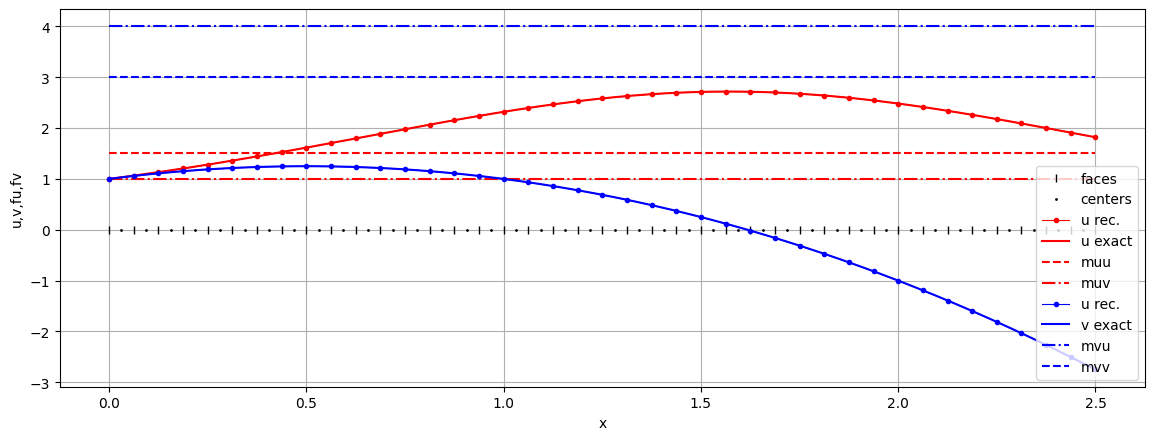

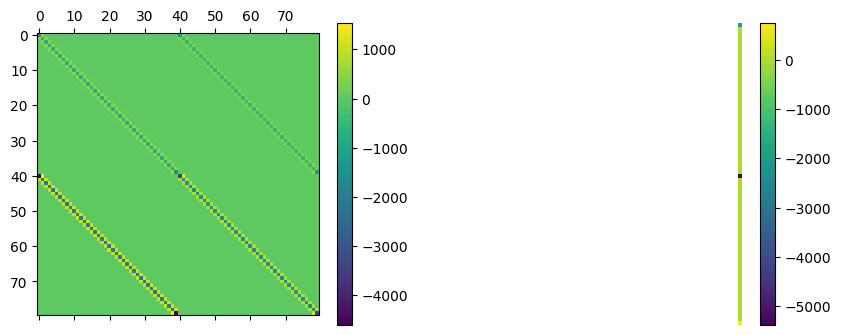

In [26]:
kwargs = {
    'a': 1.5,
    'b': 0.0,
    'c': 4.0,
    'd': 3.0,
    'e': 0.0,
    'f': 2.0
}

def fmuu(x, kwargs):
    return kwargs['a'] + kwargs['b']*np.sin(kwargs['c']*x)

def fmuv(x, kwargs):
    return 1.0 + 0.0*x

def fmvu(x, kwargs):
    return 4.0 + 0.0*x

def fmvv(x, kwargs):
    return kwargs['d'] + kwargs['e']*np.sin(kwargs['f']*x)

def sol_u(x, kwargs):
    return np.exp(np.sin(x))

def sol_v(x, kwargs):
    return 1.0 - np.square(x) + x

def f_u(x, kwargs):
    a = kwargs['a']
    b = kwargs['b']
    c = kwargs['c']
    d = kwargs['d']
    e = kwargs['e']
    f = kwargs['f']
    return np.exp(np.sin(x))*(b*c*np.cos(x)*np.cos(c*x)+(a+b*np.sin(c*x))*(np.square(np.cos(x))-np.sin(x))) -2.0*fmuv(x, kwargs)

def f_v(x, kwargs):
    a = kwargs['a']
    b = kwargs['b']
    c = kwargs['c']
    d = kwargs['d']
    e = kwargs['e']
    f = kwargs['f']
    return fmvu(x, kwargs)*(-np.sin(x)*np.exp(np.sin(x))+np.square(np.cos(x))*np.exp(np.sin(x))) + 2.0*(e*f*x*np.cos(f*x) - d - e*np.cos(f*x))

L = 2.5
N = 40
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

leftBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_u(0.0, kwargs)}

rightBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_u(L, kwargs)}

leftBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_v(0.0, kwargs)}

rightBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_v(L, kwargs)}

print(leftBC_u)
print(rightBC_u)
print(leftBC_v)
print(rightBC_v)

A, fuuBC = mylib.laplacian(fmuu, leftBC_u, rightBC_u, N, dx, L, kwargs)
B, fuvBC = mylib.laplacian(fmuv, leftBC_v, rightBC_v, N, dx, L, kwargs)
C, fvuBC = mylib.laplacian(fmvu, leftBC_u, rightBC_u, N, dx, L, kwargs)
D, fvvBC = mylib.laplacian(fmvv, leftBC_v, rightBC_v, N, dx, L, kwargs)

fu = f_u(xc, kwargs) + fuuBC + fuvBC
fv = f_v(xc, kwargs) + fvuBC + fvvBC

A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A
Z[:N,N:] = B
Z[N:,:N] = C
Z[N:,N:] = D

f = np.concatenate((fu,fv))

sol = linalg.solve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.reconstruct(u)
v_rec = mylib.reconstruct(v)

print("cond(Z) =", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

fig, ax = plt.subplots(figsize=(14,5), dpi=100)
markersize = 20
linewidth = 0.8
ax.set_xlabel('x')
ax.set_ylabel('u,v,fu,fv')

ax.plot(x, 0*x, '|', color='k', label='faces', markersize=6.0)
ax.plot(xc, 0*xc, '.', color='k', label='centers', markersize=2.0)

ax.plot(x, mylib.reconstruct(u), '.-r' , label='u rec.', linewidth=linewidth)
#ax.plot(xc, u, '_r', markersize=markersize)
ax.plot(xfine, sol_u(xfine, kwargs), '-r', label='u exact')
ax.plot(xfine, fmuu(xfine, kwargs), '--r', label='muu')
ax.plot(xfine, fmuv(xfine, kwargs), '-.r', label='muv')

ax.plot(x, mylib.reconstruct(v), '.-b' , label='u rec.', linewidth=linewidth)
#ax.plot(xc, v, '_b', markersize=markersize)
ax.plot(xfine, sol_v(xfine, kwargs), '-b', label='v exact')
ax.plot(xfine, fmvu(xfine, kwargs), '-.b', label='mvu')
ax.plot(xfine, fmvv(xfine, kwargs), '--b', label='mvv')

#ax.plot(x, mylib.reconstruct(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax.plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax.plot(xfine, f(xfine, kwargs), '--k', label='f exact')

#ax.set_ylim(bottom=0.0)
#ax.set_xlim([-0.001,0.1])
ax.legend()
ax.grid()

fig1, axs = plt.subplots(1, 2, figsize=(10,4), dpi=100)
axsZ = axs[0].matshow(Z)
axsf = axs[1].matshow(f.reshape((2*N,1)))
fig1.colorbar(axsZ, ax=axs[0])
fig1.colorbar(axsf, ax=axs[1])
axs[1].axis('off')
#plt.savefig('matrix.pdf')
plt.show()